Compare salinity from LSB model and moorings.
==

Includes SFEI moorings and NOAA tide gages.


In [28]:
from __future__ import print_function
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, dates
import numpy as np
import xarray as xr
import pandas as pd 
import glob

from stompy import utils
from stompy.grid import unstructured_grid
from stompy.model.delft import dfm_grid
%matplotlib inline

In [32]:
# Select run
root='/hpcvol1/rusty/dfm/lsb_dfm/runs'

run_name="short_summer2016_02"
dfm_dir=os.path.join(root,run_name)
dfm_out_dir=os.path.join(dfm_dir,'DFM_OUTPUT_%s'%run_name)
fn_patt=os.path.join(dfm_out_dir,'%s_0000_*_000000_his.nc'%run_name)
his_fn=glob.glob(fn_patt)[0]
print("Opening his file ",his_fn)
his=xr.open_dataset(his_fn)
fig_dir="fig-lsb_dfm-20180330_02"

os.path.exists(fig_dir) or os.makedirs(fig_dir)

Opening his file  /hpcvol1/rusty/dfm/lsb_dfm/runs/short_summer2016_02/DFM_OUTPUT_short_summer2016_02/short_summer2016_02_0000_20160601_000000_his.nc


True

In [33]:
#sfei_csv_dir='../../../../../00_Master_Data_Repository/C2_Moored_Sensors/2_Results/EXO/data/L2/'
sfei_csv_dir="/opt/data/sfei/moored_sensors_csv/L2/"

station_ds=None # set below

class SFEI(object):
    def __init__(self,sfei_file):
        self.sfei_file=sfei_file
    def df(self):
        df=pd.read_csv(os.path.join(sfei_csv_dir,self.sfei_file),
                       parse_dates=['Datetime','dt'])
        # trim to period
        df2=df[ (df.Datetime.values>station_ds.time.values[0]) 
                & (df.Datetime.values<station_ds.time.values[-1]) ]
        df2=df2.copy()
        # standardize names
        df2['time']=df2.Datetime
        df2['water_level']=df2['Depth_m']
        df2['salinity']=df2['S_PSU']
        return df2


sfei_sites=[ ('ALV',SFEI('ALV_all_data_L2.csv'),'Alviso Slough'),
             ('SFEI_Guadalupe',SFEI('GL_all_data_L2.csv'),"Guadalupe Slough"),
             ('SFEI_A8Notch',SFEI('POND_all_data_L2.csv'),'Pond A8 Feeder'),
             ('SFEI_Coyote',SFEI('COY_all_data_L2.csv'),'Coyote Creek'),
             ('SFEI_Mowry',SFEI('MOW_all_data_L2.csv'),'Mowry Slough'),
             ('SFEI_Newark',SFEI('NW_all_data_L2.csv'),'Newark Slough'),
             ('DB',SFEI('DMB_all_data_L2.csv'),'Dumbarton Bridge')
]

/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24,28,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24,28,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: 

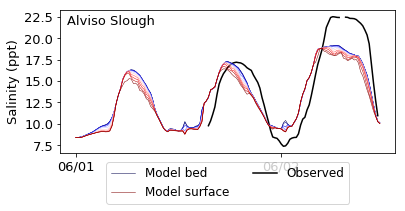

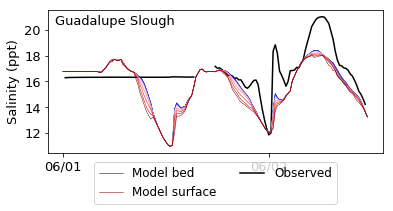

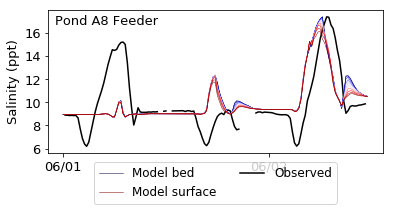

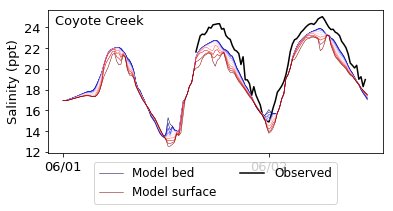

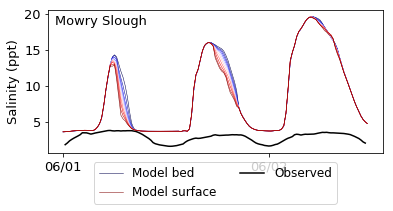

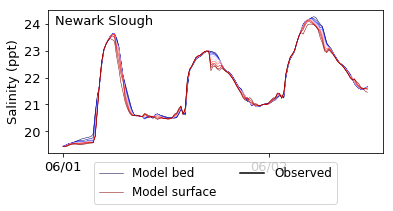

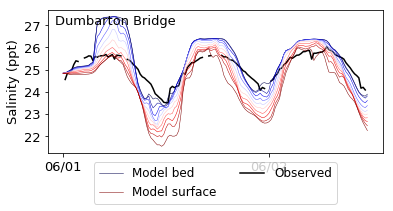

In [35]:
count=1

for dfm_name, observed, site_title in sfei_sites:
    try:
        b_dfm_name=dfm_name.encode()
    except AttributeError:
        b_dfm_name=dfm_name
    
    img_fn=os.path.join(fig_dir,'salt_comparison-%s-v01.png'%(dfm_name))
    # if os.path.exists(img_fn):
    #     print("Skipping %s"%dfm_name)
    #     continue

    # set this before calling df(), as it looks for station_ds inside
    # that method
    idx=np.nonzero( (his.station_name==b_dfm_name).values )[0][0]
    station_ds=his.isel(stations=idx)

    # these should come in as UTC
    mooring_df=observed.df()

    fig=plt.figure(count)
    fig.clf()
    fig.set_size_inches( (6,3), forward=True )

    fig,ax=plt.subplots(num=count)
    count+=1
    
    if 1: # all layers, color-coded
        for layi,laydim in enumerate(station_ds.laydim.values):
            if 0: # less color
                col='k'
                if layi==0:
                    label='Model'
                else:
                    label='__nolabel__'
                obs_col='g'
            else:
                Nlay=len(station_ds.laydim)
                col=cm.seismic( layi / float(Nlay-1) )
                if layi==0:
                    label='Model bed'
                elif layi==Nlay-1:
                    label='Model surface'
                else:
                    label='__nolabel__'
                obs_col='k'
            dnums=utils.to_dnum(station_ds.time.values)
            salinity=station_ds.salinity.isel(laydim=layi).values
            ax.plot(dnums,salinity,
                    color=col,label=label,lw=0.5)
    else: # top,bottom, shaded between
        obs_col='k'
        ax.fill_between(utils.to_dnum(station_ds.time),
                        station_ds.salinity.isel(stations=0).min(dim='laydim').values,
                        station_ds.salinity.isel(stations=0).max(dim='laydim').values,
                        color='r',label='Model',lw=2.0,zorder=-1)
                        
    ax.plot(utils.to_dnum(mooring_df.time.values),
            mooring_df.salinity,
            color=obs_col,label='Observed',zorder=-1)

    ax.set_ylabel('Salinity (ppt)')
    #ax.legend(fontsize=9)
    ax.legend(fontsize=12,ncol=2,
              loc='lower center',
              bbox_to_anchor=[0.5,-0.40])
    fig.subplots_adjust(bottom=0.3,top=0.96)

    s_max=max( station_ds.salinity.max(), mooring_df.salinity.max() )
    s_min=min( station_ds.salinity.min(), mooring_df.salinity.min() )
    s_pad=0.05*(s_max-s_min)
    
    #ax.axis( xmin=736119.0, xmax=736121.8,
    #         ymin=s_min-s_pad,ymax=s_max+3.1*s_pad)

    #ax.set_title(site_title)
    ax.text(0.02,0.97,site_title,fontsize=13,transform=ax.transAxes,
            va='top')

    if 0:
        fig.autofmt_xdate()
    else:
        ax.xaxis.set_major_locator( dates.DayLocator() )
        ax.xaxis.set_major_formatter( dates.DateFormatter("%m/%d") )

    plt.setp(ax.xaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_label(),fontsize=13)

    fig.savefig(img_fn,dpi=150)